In [14]:
%matplotlib inline

In [1]:
import boto3
import pandas as pd
import numpy as np
from pathlib import Path
import json
import re

from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL

In [2]:
import s3fs

# Avante

In [2]:
secret_name = "cust_db_credentials"
region_name = "us-east-1"

# Create a Secrets Manager client
session = boto3.session.Session()
client = session.client(service_name="secretsmanager", region_name=region_name)

get_secret_value_response = client.get_secret_value(SecretId=secret_name)

db_info = json.loads(get_secret_value_response["SecretString"])

avan_connect_url = URL(
    drivername="mssql+pyodbc",
    username=db_info["username"],
    password=db_info["password"],
    host=db_info["host"],
    database="AVAN",
    query={'driver': 'ODBC Driver 17 for SQL Server'}
)

avan_engine = create_engine(avan_connect_url)

In [4]:
train_start_date = '2011-01-01'
train_end_date = '2019-02-28'
test_end_date = '2019-06-26'

In [5]:
query = f'''
select [FacilityID]
      ,[ProgressNoteID]
      ,[PatientID]
      ,[ProgressNoteType]
      ,[EffectiveDate]
      ,[Retired]
      ,[RetiredBy]
      ,[RetiredDate]
      ,[Section]
      ,[SectionSequence]
      ,[NoteText]
      ,[NoteTextOrder]
      ,[CreatedBy]
      ,[CreatedDate]
      ,[RevisionBy]
      ,[RevisionDate]
from view_ods_progress_note
where createddate between '{train_start_date}' and '{test_end_date}'
AND CAST(CreatedDate as Date) = CAST(RevisionDate as Date) AND Deleted = 'N'
'''

df = pd.read_sql(query, avan_engine)

In [6]:
print('Data Pulled')

Data Pulled


In [7]:
df.to_parquet(f's3://saiva-restricted-data/raw/avante_progress_notes_{train_start_date}_{test_end_date}.parquet')

In [15]:
full_df = full_df.append(df)

In [16]:
full_df.to_parquet(f's3://saiva-restricted-data/raw/avante_progress_notes_{train_start_date}_{test_end_date}.parquet')

In [17]:
len(full_df)

10408503

# Greystone

In [4]:
grey_connect_url = URL(
    drivername="mssql+pyodbc",
    username='saiva',
    password='Saiva27360!',
    host='172.0.95.223',
    database="pcc_replica_saiva",
    port=1433,
    query={'driver': 'ODBC Driver 17 for SQL Server'}
)

grey_engine = create_engine(grey_connect_url)

In [6]:
query = f'''
select [FacilityID]
      ,[ProgressNoteID]
      ,[PatientID]
      ,[ProgressNoteType]
      ,[EffectiveDate]
      ,[Section]
      ,[SectionSequence]
      ,[NoteText]
      ,[NoteTextOrder]
      ,[CreatedBy]
      ,[CreatedDate]
      ,[RevisionBy]
      ,[RevisionDate]
FROM [pcc_replica_saiva].[dbo].[ods_progress_note]
where createddate < '2019-06-15'
'''

df = pd.read_sql(query, grey_engine)

In [7]:
len(df)

11913897

In [8]:
df.to_parquet(f's3://saiva-restricted-data/raw/greystone_progress_notes_all_time.parquet')

In [9]:
df.to_parquet('/code/data/raw/greystone_progress_notes_all_time.parquet')

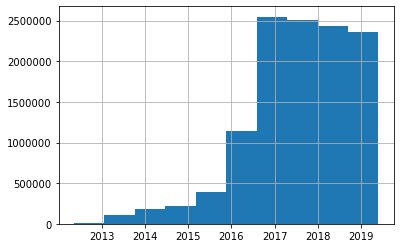

In [15]:
df['CreatedDate'].hist()